In [2]:
import tensorflow as tf
from tensorflow.contrib.layers import conv2d, avg_pool2d, max_pool2d, conv2d_transpose, dropout
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle

In [3]:
dim = 128

In [4]:
data = tf.placeholder(tf.float32, shape=(None, dim, dim, 3))
labels = tf.placeholder(tf.int64, shape=(None, dim, dim, 1))

In [5]:
def combine(copied, convd):
    with tf.name_scope('crop_combine'):
        target_height, target_width = convd.get_shape().as_list()[1:-1]
        cropped = tf.image.resize_image_with_crop_or_pad(copied, target_height, target_width)
        return tf.concat((cropped, convd), axis=-1)

In [6]:
def down(name, data, output_size):
    with tf.name_scope(name):
        layer = max_pool2d(data, (2, 2))
        layer = conv2d(layer, output_size, (3, 3))
        layer = dropout(layer, keep_prob=0.85)
        return conv2d(layer, output_size, (3, 3))

In [7]:
def up(name, data_across, data_up, output_size):
    with tf.name_scope(name):
        data_up = conv2d_transpose(data_up, output_size, (3, 3), stride=2)
        combined = combine(data_across, data_up)
        layer = conv2d(combined, output_size, (3, 3))
        layer = dropout(layer, keep_prob=0.85)
        return conv2d(layer, output_size, (3, 3))

In [8]:
with tf.device('/gpu:0'):
    with tf.name_scope('group1'):
        group1 = conv2d(data, 64, (3, 3))
        group1 = conv2d(group1, 64, (3, 3))

    group2 = down('group2_down', group1, 128)
    group3 = down('group3_down', group2, 256)
    group4 = down('group4_down', group3, 512)
#     group5 = down('group5_down', group4, 1024)

#     group6 = up('group6_up', group4, group5, 512)
    group7 = up('group7_up', group3, group4, 256)
    group8 = up('group8_up', group2, group7, 128)
    group9 = up('group9_up', group1, group8, 64)

    output = conv2d(group9, 2, (1, 1), activation_fn=None)
    output_soft = tf.nn.softmax(output)

    # 2x2
    down_sampled = max_pool2d(output_soft, kernel_size=(64, 64), stride=(64, 64), padding='VALID')
    pooled_label = max_pool2d(tf.cast(labels, tf.float16), kernel_size=(64, 64), stride=(64, 64), padding='VALID')
    label_down_sampled = tf.cast(pooled_label, tf.int64)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=label_down_sampled, logits=down_sampled)
    
    prediction = tf.argmax(down_sampled, axis=-1)
    correct = tf.cast(tf.equal(prediction, tf.squeeze(label_down_sampled)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    
    # 16x16
    down_sampled16 = max_pool2d(output_soft, kernel_size=(64, 64), stride=(64, 64), padding='VALID')
    pooled_label16 = max_pool2d(tf.cast(labels, tf.float16), kernel_size=(64, 64), stride=(64, 64), padding='VALID')
    label_down_sampled16 = tf.cast(pooled_label16, tf.int64)
    loss16 = tf.losses.sparse_softmax_cross_entropy(labels=label_down_sampled16, logits=down_sampled16)
    
    prediction16 = tf.argmax(down_sampled16, axis=-1)
    correct16 = tf.cast(tf.equal(prediction16, tf.squeeze(label_down_sampled16)), tf.float32)
    accuracy16 = tf.reduce_mean(correct16)

In [9]:
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss) # 2x2 grid loss
train_step16 = tf.train.AdamOptimizer(0.00001).minimize(loss16) #16x16 grid loss

In [10]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement = True))
writer = tf.summary.FileWriter("viz", sess.graph)
writer.close()

In [11]:
def data_iter(train_test, batch_size=32):
    x = []
    y = []
    filenames = os.listdir('cancer_data/inputs')
    shuffle(filenames)
    for filename in filenames:
        if train_test in filename and 'pos' in filename:
            image = Image.open('cancer_data/inputs/' + filename)
            image = np.array(image.resize((dim, dim))).reshape((dim, dim, 3)) / 255.
            x.append(image)
            image = Image.open('cancer_data/outputs/' + filename)
            image = np.array(image.resize((dim, dim))).reshape((dim, dim, 1)) / 255.
            y.append(image)
        if len(x) == batch_size:
            yield x, y
            x = []
            y = []

In [12]:
sess.run(tf.global_variables_initializer())
batch_size = 16
train_acc_over_time = []
train_loss_over_time = []
val_acc_over_time = []
val_loss_over_time = []
for e in range(10):
    train_iter = data_iter('train', batch_size=batch_size)
    train_loss = []
    train_acc = []
    for i in range(int(600 / batch_size)):
        x, y = next(train_iter)
        if len(x) == 0:
            break
        _, out_res, loss_res, acc_res = sess.run([train_step, output_soft, loss, accuracy], 
                                                 {data: x, labels: y})
        train_loss.append(loss_res)
        train_acc.append(acc_res)
    print("epoch", e + 1, "train loss:", sum(train_loss) / len(train_loss), \
          "train accuracy:", sum(train_acc) / len(train_acc))
    
    train_loss_over_time += train_loss
    train_acc_over_time += train_acc
    
    test_iter = data_iter('test', batch_size=75)
    x, y = next(test_iter)
    ds, loss_res, acc_res = sess.run([label_down_sampled, loss, accuracy], {data: x, labels: y})
    val_acc_over_time.append(acc_res)
    val_loss_over_time.append(loss_res)
    print("val loss:", loss_res, 'val acc:', acc_res)

epoch 1 train loss: 0.667596601151 train accuracy: 0.622466216216
val loss: 0.692853 val acc: 0.57
epoch 2 train loss: 0.647061739419 train accuracy: 0.649070945946
val loss: 0.699818 val acc: 0.57
epoch 3 train loss: 0.628404675303 train accuracy: 0.634290540541
val loss: 0.648918 val acc: 0.57
epoch 4 train loss: 0.580547571182 train accuracy: 0.694256756757
val loss: 0.633851 val acc: 0.7
epoch 5 train loss: 0.557937352238 train accuracy: 0.714949324324
val loss: 0.640747 val acc: 0.623333
epoch 6 train loss: 0.565575769624 train accuracy: 0.709881756757
val loss: 0.663721 val acc: 0.673333
epoch 7 train loss: 0.55654968281 train accuracy: 0.720439189189
val loss: 0.633725 val acc: 0.636667
epoch 8 train loss: 0.562818226782 train accuracy: 0.693412162162
val loss: 0.652513 val acc: 0.623333
epoch 9 train loss: 0.565352745958 train accuracy: 0.691300675676
val loss: 0.631609 val acc: 0.68
epoch 10 train loss: 0.553803832144 train accuracy: 0.696368243243
val loss: 0.627175 val acc: 

In [13]:
for e in range(5):
    train_iter = data_iter('train', batch_size=batch_size)
    train_loss = []
    train_acc = []
    for i in range(int(600 / batch_size)):
        x, y = next(train_iter)
        if len(x) == 0:
            break
        _, out_res, loss_res, acc_res = sess.run([train_step16, output_soft, loss16, accuracy16], 
                                                 {data: x, labels: y})
        train_loss.append(loss_res)
        train_acc.append(acc_res)
    print("epoch", e + 1, "train loss:", sum(train_loss) / len(train_loss), \
          "train accuracy:", sum(train_acc) / len(train_acc))
    
    train_loss_over_time += train_loss
    train_acc_over_time += train_acc
    
    test_iter = data_iter('test', batch_size=75)
    x, y = next(test_iter)
    ds, loss_res, acc_res = sess.run([label_down_sampled16, loss16, accuracy16], {data: x, labels: y})
    val_acc_over_time.append(acc_res)
    val_loss_over_time.append(loss_res)
    print("val loss:", loss_res, 'val acc:', acc_res)

epoch 1 train loss: 0.550315696645 train accuracy: 0.725929054054
val loss: 0.624698 val acc: 0.683333
epoch 2 train loss: 0.54810091692 train accuracy: 0.728040540541
val loss: 0.624977 val acc: 0.686667
epoch 3 train loss: 0.550234505454 train accuracy: 0.722550675676
val loss: 0.625051 val acc: 0.686667
epoch 4 train loss: 0.543170046162 train accuracy: 0.734797297297
val loss: 0.625234 val acc: 0.676667
epoch 5 train loss: 0.543797547753 train accuracy: 0.732685810811
val loss: 0.624996 val acc: 0.68


### Topology
I used the u-net exactly as described in the lab description, except that I left the lowest layer out and got better results that way. 

### Cost Function
I used two different loss functions. For my first 10 epochs I did modified pixel-by-pixel cross-entropy, where I max-pooled my output and label so that it was just a 2x2 grid. In other words, I measured whether there was cancer in each quadrant of the image. This allowed my net to learn despite class imbalance. The baseline (guessing) accuracy was about 57%, which the net learned up to about 70% on the validation set.

After my net had learned a little bit, I continued training with a separate loss function which employs the same technique as above, except that it downsamples my output image into a 16x16 image rather than a 2x2. This allows the net to continue learning and to localize better. This also got about 71% test accuracy, and the following output image:

In [14]:
img = np.array(Image.open('cancer_data/inputs/pos_test_000072.png').resize((128, 128)))
out_img = sess.run(output_soft, {data: [img]})

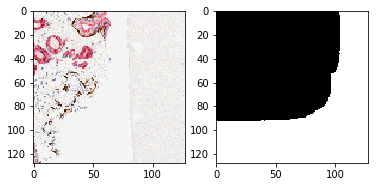

In [15]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(out_img[0,:,:,0], cmap='gray')
plt.show()

### Accuracy
My accuraccy calculation was the same as my loss. Pixel-wise, but on a highly down-sampled, max-pooled image and label to expand the region of interest. 

### Regularization
I used dropout between each pair of convolutions (i.e. one per 'group' in the u-net architecture) with `keep_prob=.85`. It makes it take longer to converge, and I don't seem to be getting better generalizability either with this particular model.

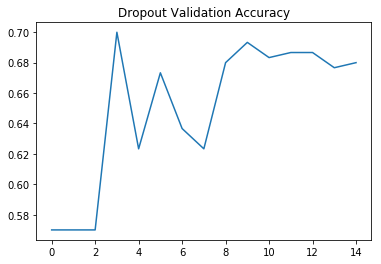

In [16]:
plt.plot(val_acc_over_time)
plt.xlabel='epoch'
plt.ylabel='validation accuracy'
plt.title('Dropout Validation Accuracy')
plt.show()

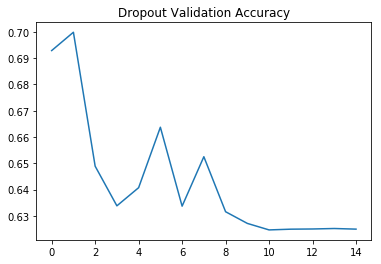

In [17]:
plt.plot(val_loss_over_time)
plt.xlabel='epoch'
plt.ylabel='validation accuracy'
plt.title('Dropout Validation Accuracy')
plt.show()